# Selection Task
#### Suvid Singhal

I used an NVIDIA RTX 3050 for this task but the code will work on CPU as well

Fulfilled all the requirements by implementing the following:
- Organized the dataset for one-vs-rest (binary) classification
- Organized the dataset for 5-class classification
- Performed binary classification using existing architecture (pre-trained AlexNet)
- Performed 5-class classification using existing architecture (pre-trained AlexNet)
- Performed binary classification using existing architecture (AlexNet trained from scratch on the given dataset)
- Performed 5-class classification using existing architecture (AlexNet trained from scratch on the given dataset)
- Created a custom model for binary classification and trained it on the given dataset
- Created a custom model for 5-class classification and trained it on the given dataset
- Used 3-fold validation for calculating the accuracies of the models
- Generated classification matrices for the models and also calculated accuracy using it
- Visualized the output of all the convolutional layers for different classes in the custom CNN model
- Discussed my insights on the automatically created features by the custom CNN

I was not able to upload pre-trained models on GitHub due to size limit
### Download the entire code and my trained models here:
### [Click Here](https://drive.google.com/drive/folders/1Pb5a-NpP4SW-E9FfP1hIZjBD4k_Gz95t?usp=drive_link)


The directory structure should look like this:
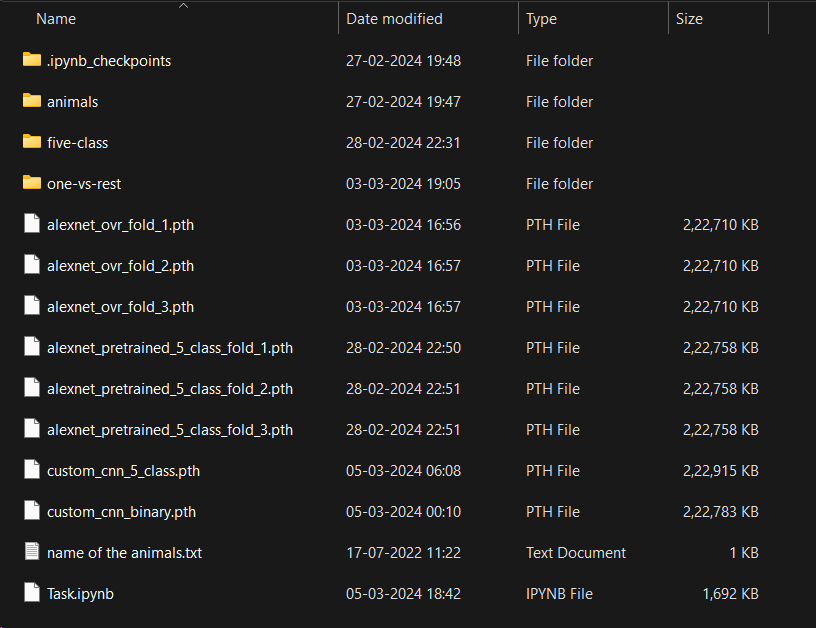

## Restructuring for One-vs-Rest

The "animals" directory contains 90 different labels and each folder contains 60 images of each animal

For One-vs-Rest classification, we'll choose bat as our positive sample

The following code creates the appropriate directory structure, if it does not exist.

This notebook must be present in the same directory as the "animal" directory for the code to work.

Selecting 5 random images from each class to build the "others" label.

In [5]:
import os
import shutil
import random
src_folder = "animals/bat"
folders = os.listdir("animals")
temp = []
for folder in folders:
    if folder != "bat":
        temp.append([os.path.join("animals/"+folder, file) for file in random.sample(os.listdir("animals/"+folder),1)])
to_copy=[]
for temp_list in temp:
    for item in temp_list:
        to_copy.append(item)
if not os.path.exists("one-vs-rest"):
    shutil.copytree(src_folder, "one-vs-rest/bat")
    os.mkdir("one-vs-rest/others")
    for file_name in to_copy:
        shutil.copy2(file_name, "one-vs-rest/others/")

## Using pre-trained existing architecture (AlexNet) for binary classification (One vs Rest)

In [149]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

num_epochs = 10

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root='one-vs-rest/', transform=transform)

# Define k-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

accuracies=[]

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    # Split dataset into train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Load pre-trained AlexNet model
    model = torchvision.models.alexnet(pretrained=True)

    # Freeze the parameters of the pre-trained layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer for binary classification
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 2)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{5}, Training Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), f'alexnet_ovr_fold_{fold+1}.pth')

print("\nFinal Mean Accuracy:", '{0:.4f}'.format(np.mean(accuracies)))

Fold 1


C:\Users\suvid\.conda\envs\intern\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\suvid\.conda\envs\intern\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Training Loss: 0.4932
Epoch 2/5, Training Loss: 0.1409
Epoch 3/5, Training Loss: 0.0635
Epoch 4/5, Training Loss: 0.0384
Epoch 5/5, Training Loss: 0.0199
Validation Accuracy: 0.9625
Fold 2
Epoch 1/5, Training Loss: 0.5235
Epoch 2/5, Training Loss: 0.1369
Epoch 3/5, Training Loss: 0.0816
Epoch 4/5, Training Loss: 0.0291
Epoch 5/5, Training Loss: 0.0238
Validation Accuracy: 0.8861
Fold 3
Epoch 1/5, Training Loss: 0.6815
Epoch 2/5, Training Loss: 0.2231
Epoch 3/5, Training Loss: 0.1060
Epoch 4/5, Training Loss: 0.0705
Epoch 5/5, Training Loss: 0.0449
Validation Accuracy: 0.9620

Final Mean Accuracy: 0.9369


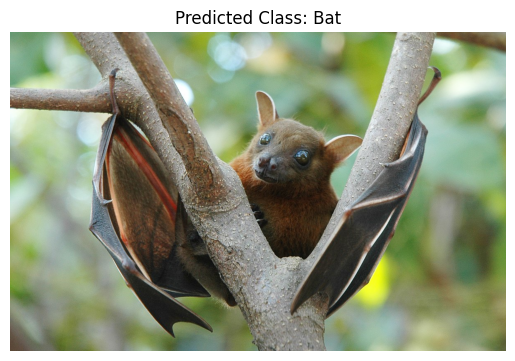

In [29]:
#Predicting

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = torchvision.models.alexnet(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 2)

# Load the saved state dictionary
state_dict = torch.load('alexnet_ovr_fold_1.pth')

# Remove the 'module.' prefix if present (for loading from a DataParallel model)
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

# Define transforms for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'C:\\Users\\suvid\\Desktop\\fruitbat.jpg'  # Replace with the path to your image
image = Image.open(image_path)
image = image.convert("RGB")

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Perform prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Get class label
class_labels = ['Bat', 'Others']
predicted_label = class_labels[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


## Restructuring for 5 Class Classification

We're taking 5 labels: cat, cow, octopus, oyster and panda

In [367]:
import os
import shutil
import random

if not os.path.exists("five-class"):
    shutil.copytree("animals/cat", "five-class/cat")
    shutil.copytree("animals/cow", "five-class/cow")
    shutil.copytree("animals/octopus", "five-class/octopus")
    shutil.copytree("animals/oyster", "five-class/oyster")
    shutil.copytree("animals/panda", "five-class/panda")


## 5-Class Classification using pre-trained AlexNet

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = torchvision.datasets.ImageFolder(root='five-class/', transform=transform)

# Define k-fold cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

accuracies=[]

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"Fold {fold+1}")

    # Split dataset into train and validation subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Load pre-trained AlexNet model
    model = torchvision.models.alexnet(pretrained=True)

    # Modify the final fully connected layer for 5-class classification
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)  # 5 output classes for 5-class classification

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # Train the model
    for epoch in range(5):  # Number of epochs
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{5}, Training Loss: {epoch_loss:.4f}")

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), f'alexnet_pretrained_5_class_fold_{fold+1}.pth')

print("\nFinal Mean Accuracy:", '{0:.4f}'.format(np.mean(accuracies)))

Fold 1
Epoch 1/5, Training Loss: 2.0340
Epoch 2/5, Training Loss: 1.5618
Epoch 3/5, Training Loss: 1.2037
Epoch 4/5, Training Loss: 0.9442
Epoch 5/5, Training Loss: 0.7466
Validation Accuracy: 0.8000
Fold 2
Epoch 1/5, Training Loss: 1.8057
Epoch 2/5, Training Loss: 1.3289
Epoch 3/5, Training Loss: 0.9609
Epoch 4/5, Training Loss: 0.7331
Epoch 5/5, Training Loss: 0.5253
Validation Accuracy: 0.8100
Fold 3
Epoch 1/5, Training Loss: 1.7709
Epoch 2/5, Training Loss: 1.3511
Epoch 3/5, Training Loss: 0.9841
Epoch 4/5, Training Loss: 0.7640
Epoch 5/5, Training Loss: 0.5536
Validation Accuracy: 0.7900

Final Mean Accuracy: 0.8000


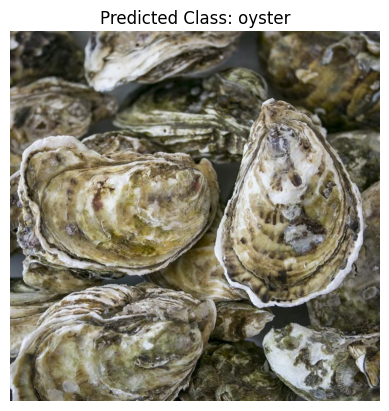

In [25]:
#Predicting

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = torchvision.models.alexnet(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, 5)

# Load the saved state dictionary
state_dict = torch.load('alexnet_pretrained_5_class_fold_1.pth')

# Remove the 'module.' prefix if present (for loading from a DataParallel model)
if 'module.' in list(state_dict.keys())[0]:
    state_dict = {k[7:]: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)

model.eval()

# Define transforms for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = 'C:\\Users\\suvid\\Desktop\\oyster2.jpg'
image = Image.open(image_path)
image = image.convert("RGB")

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)

# Perform prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()

# Get class label
class_labels = ["Cat", "Cow", "Octopus", "Oyster","Panda"]
predicted_label = class_labels[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


# Custom Model Development

## Binary Classification

In [106]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, SubsetRandomSampler, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)

### Data Augmentation

In [107]:
# Tried to expand the dataset using data augmentation in order to improve accuracy as the dataset given was small

batch_size = 5
num_epochs = 15
learning_rate=0.001

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augmentation transforms
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Normal transforms
std_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset1 = datasets.ImageFolder('one-vs-rest/', transform=std_transform)
dataset2 = datasets.ImageFolder('one-vs-rest/', transform=aug_transform)
dataset = ConcatDataset([dataset1, dataset2])
test_dataset = dataset

True


tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1])


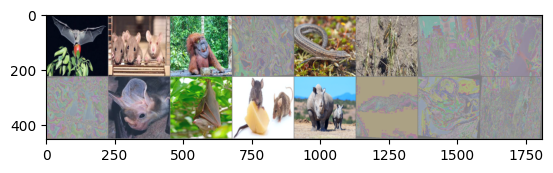

In [108]:
# show random images after loading the data

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset, batch_size=16, shuffle=True)

def imshow(img):
    # Unnormalize the image tensor
    img = img * 0.229 + 0.485  # Undo normalization
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)  # clip values to stay within valid range
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
# Our Model for training

# Experimented with batch normalization layers to improve accuracy, there is stil room for improvement in accuracy
class ConvNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
            nn.Sigmoid(),
        )
        self.intermediate_activations = []

        # Register hooks to store intermediate activations
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # Store intermediate activations
        self.intermediate_activations.append(output)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, self.intermediate_activations


model = ConvNet().to(device)


In [109]:
# Our Model for getting the output of the convolutional layers

# Experimented with batch normalization layers to improve accuracy, there is stil room for improvement in accuracy
class ConvNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            #nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
            nn.Sigmoid(),
        )
        self.intermediate_activations = []

        # Register hooks to store intermediate activations
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # Store intermediate activations
        self.intermediate_activations.append(output)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, self.intermediate_activations


model = ConvNet().to(device)


In [8]:
# Define K-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs = 10
accuracies = []

# Iterate through each fold
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    # Split the augmented dataset into train and test sets for this fold
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)

    # Create DataLoader for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    model = ConvNet().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        print(f'Fold {fold+1}, Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader.dataset):.4f}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()

    accuracy = 100 * correct / total
    print(f'Fold {fold+1}, Test Accuracy: {accuracy:.2f}%')
    accuracies.append(accuracy)

# Final accuracy
print("Final accuracy:", np.mean(accuracies))

Fold 1, Epoch 1, Training Loss: 1.8056
Fold 1, Epoch 2, Training Loss: 0.8210
Fold 1, Epoch 3, Training Loss: 0.7612
Fold 1, Epoch 4, Training Loss: 0.7211
Fold 1, Epoch 5, Training Loss: 0.6779
Fold 1, Epoch 6, Training Loss: 0.6805
Fold 1, Epoch 7, Training Loss: 0.6489
Fold 1, Epoch 8, Training Loss: 0.7281
Fold 1, Epoch 9, Training Loss: 0.6556
Fold 1, Epoch 10, Training Loss: 0.7384
Fold 1, Test Accuracy: 66.00%
Fold 2, Epoch 1, Training Loss: 1.3068
Fold 2, Epoch 2, Training Loss: 0.8174
Fold 2, Epoch 3, Training Loss: 0.9282
Fold 2, Epoch 4, Training Loss: 0.7603
Fold 2, Epoch 5, Training Loss: 0.7085
Fold 2, Epoch 6, Training Loss: 0.7218
Fold 2, Epoch 7, Training Loss: 0.7205
Fold 2, Epoch 8, Training Loss: 0.7907
Fold 2, Epoch 9, Training Loss: 0.6886
Fold 2, Epoch 10, Training Loss: 0.6475
Fold 2, Test Accuracy: 63.64%
Fold 3, Epoch 1, Training Loss: 2.1440
Fold 3, Epoch 2, Training Loss: 0.8926
Fold 3, Epoch 3, Training Loss: 0.8780
Fold 3, Epoch 4, Training Loss: 0.6678
Fo

In [342]:
# run this to save the model with best accuracy on the disk

torch.save(model.state_dict(), 'custom_cnn_binary.pth')

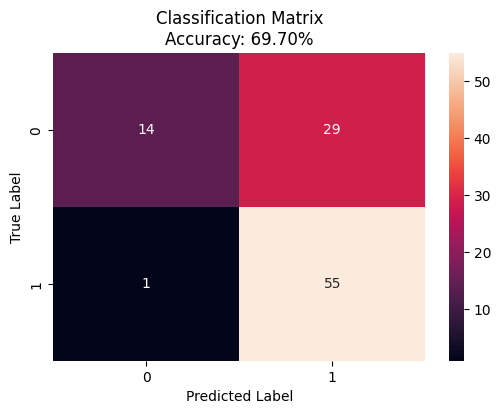

In [9]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your model
model = ConvNet()

# Load the model state dictionary
model_path = 'custom_cnn_binary.pth'
model.load_state_dict(torch.load(model_path))

model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Iterate over the test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy().flatten())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
accuracy = (conf_matrix.diagonal().sum() / conf_matrix.sum()) * 100

# Plot the classification matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Classification Matrix\nAccuracy: {accuracy:.2f}%')
plt.show()


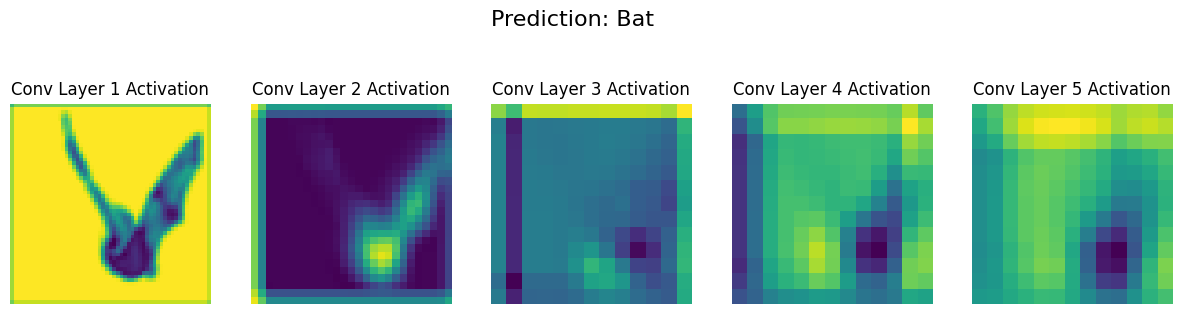

In [11]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, prediction, actual):
    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images - 1) // cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}', fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_binary.pth'
model = ConvNet()

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

labels = ['Bat', 'Others']

# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Shuffle the data list to ensure randomness
random.shuffle(data_list)

# Iterate through the data list until a same prediction as the actual label is obtained
for input_image, input_label in data_list:
    actual = labels[input_label.cpu()]
    
    model.eval()
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
    if prediction == actual:
        activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
        activation_images_resized = [np.mean(image, axis=0) for image in activation_images]
        titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

        # Plot intermediate activations in a grid
        plot_grid(activation_images_resized, titles, prediction, actual)
        break


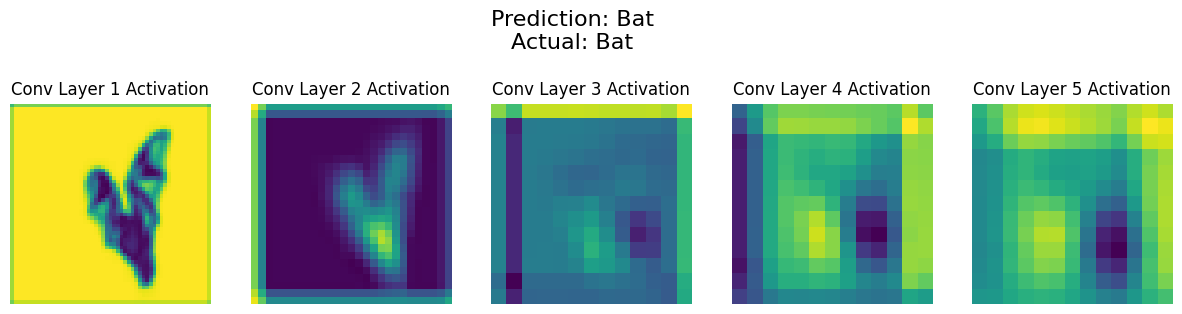

In [117]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, prediction, actual):
    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images - 1) // cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}', fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_binary.pth'
model = ConvNet()

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

labels = ['Bat', 'Others']

# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Shuffle the data list to ensure randomness
random.shuffle(data_list)

# Iterate through the data list until a same prediction as the actual label is obtained
for input_image, input_label in data_list:
    actual = labels[input_label.cpu()]
    
    model.eval()
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
    if prediction == actual:
        activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
        activation_images_resized = [np.mean(image, axis=0) for image in activation_images]
        titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

        # Plot intermediate activations in a grid
        plot_grid(activation_images_resized, titles, prediction, actual)
        break


<Figure size 640x480 with 0 Axes>

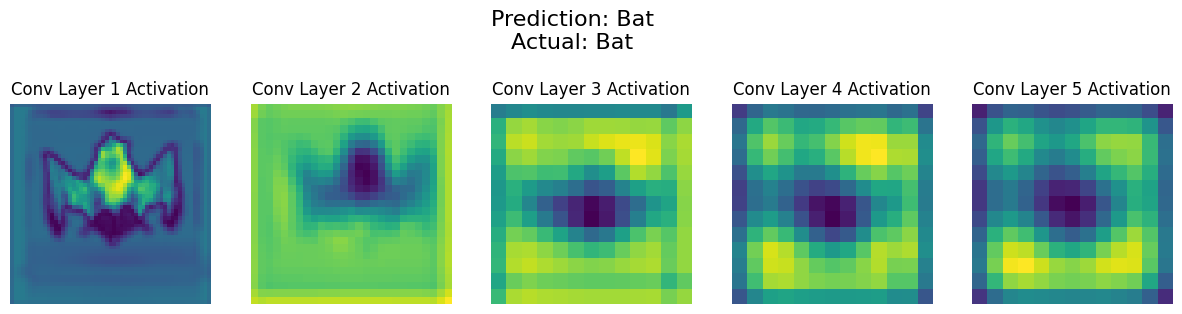

In [130]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, prediction, actual):
    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images - 1) // cols + 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}', fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_binary.pth'
model = ConvNet()

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

labels = ['Bat', 'Others']

# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Shuffle the data list to ensure randomness
random.shuffle(data_list)

# Iterate through the data list until a same prediction as the actual label is obtained
for input_image, input_label in data_list:
    actual = labels[input_label.cpu()]
    
    model.eval()
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
    if prediction == actual:
        activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
        activation_images_resized = [np.mean(image, axis=0) for image in activation_images]
        titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

        # Plot intermediate activations in a grid
        plot_grid(activation_images_resized, titles, prediction, actual)
        break


### Discussing automatically created features for identification of Bat
- The model identifies the head like structure between two triangular shaped wings
- Head or lower body both can work provided they are between two triangular shaped wings
- It then focusses more on the head and then on the wings
- Eventually, as we move on from one layer to another, the focus on wings also decrease, but the focus on the head increases

## Binary Classification Using AlexNet architecture (Not pre-trained)

In [359]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torchvision.models import alexnet
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = alexnet().features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define transformations and create dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('one-vs-rest/', transform=transform)

# Split dataset into three folds using KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

all_labels = []
all_predictions = []

# Step 4: Train and evaluate the model for each fold
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    train_sampler = SubsetRandomSampler(train_index)
    test_sampler = SubsetRandomSampler(test_index)
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)

    # Define model, loss function, and optimizer
    model = AlexNet(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on test data
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

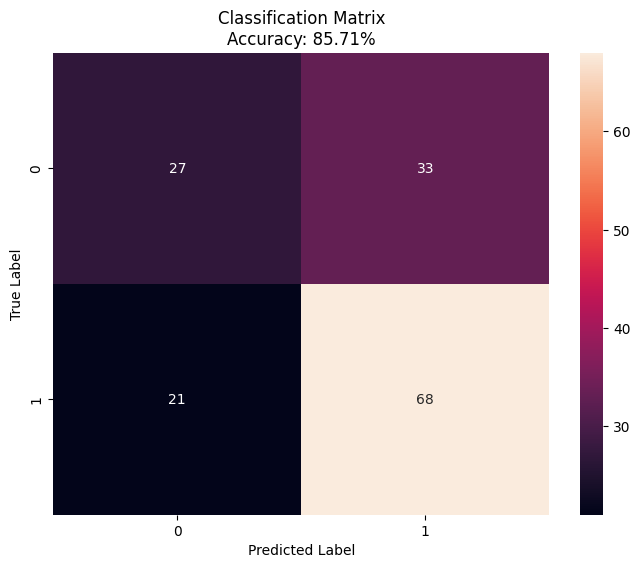

In [362]:
# Compute overall classification matrix
cm = classification_matrix(all_labels, all_predictions)

accuracy = (conf_matrix.diagonal().sum() / conf_matrix.sum()) * 100

# Plot the classification matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title(f'Classification Matrix\nAccuracy: {accuracy:.2f}%')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5-Class Classification using Custom CNN

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, SubsetRandomSampler, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)

### Data Augmentation

In [6]:
# Tried to expand the dataset using data augmentation in order to improve accuracy as the dataset given was small

batch_size = 5
num_epochs = 15
learning_rate=0.001

print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augmentation transforms
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

# Normal transforms
std_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset1 = datasets.ImageFolder('five-class/', transform=std_transform)
dataset2 = datasets.ImageFolder('five-class/', transform=aug_transform)
dataset = ConcatDataset([dataset1, dataset2])
test_dataset = dataset

True


tensor([4, 2, 3, 3, 4, 4, 3, 4, 4, 0, 3, 0, 1, 4, 2, 4])


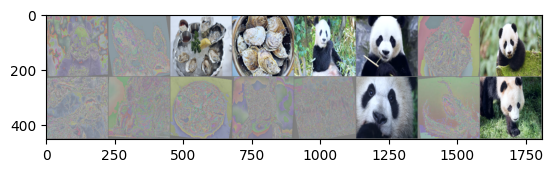

In [3]:
# show random images after loading the data

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

def imshow(img):
    # Unnormalize the image tensor
    img = img * 0.229 + 0.485
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))

In [24]:
# Our Model for training

# Experimented with batch normalization layers to improve accuracy, there is stil room for improvement in accuracy
class ConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = ConvNet().to(device)



In [4]:
# Our Model for getting the output of the convolutional layers

# Experimented with batch normalization layers to improve accuracy, there is stil room for improvement in accuracy
class ConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
            #nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            #nn.BatchNorm1d(4096),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )
        
        self.intermediate_activations = []

        # Register hooks to store intermediate activations
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # Store intermediate activations
        self.intermediate_activations.append(output)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, self.intermediate_activations

model = ConvNet().to(device)



In [19]:
# Define K-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs = 10
accuracies = []

# Iterate through each fold
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    # Split the augmented dataset into train and test sets for this fold
    train_dataset = torch.utils.data.Subset(dataset, train_index)
    test_dataset = torch.utils.data.Subset(dataset, test_index)

    # Create DataLoader for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Define your model, loss function, and optimizer
    model = ConvNet(num_classes=5).to(device)  # Assuming 5 output classes
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            #outputs, intermediate_activations = model(inputs)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Print training statistics
        print(f'Fold {fold+1}, Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader.dataset):.4f}')

    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            #outputs, intermediate_activations = model(inputs)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Fold {fold+1}, Test Accuracy: {accuracy:.2f}%')
    accuracies.append(accuracy)

# Final accuracy
print("Final accuracy:", np.mean(accuracies))


Fold 1, Epoch 1, Training Loss: 1.5476
Fold 1, Epoch 2, Training Loss: 1.2713
Fold 1, Epoch 3, Training Loss: 1.0316
Fold 1, Epoch 4, Training Loss: 0.9983
Fold 1, Epoch 5, Training Loss: 0.9220
Fold 1, Epoch 6, Training Loss: 0.8885
Fold 1, Epoch 7, Training Loss: 0.8359
Fold 1, Epoch 8, Training Loss: 0.7286
Fold 1, Epoch 9, Training Loss: 0.8208
Fold 1, Epoch 10, Training Loss: 0.7024
Fold 1, Test Accuracy: 56.00%
Fold 2, Epoch 1, Training Loss: 1.6129
Fold 2, Epoch 2, Training Loss: 1.1900
Fold 2, Epoch 3, Training Loss: 1.0651
Fold 2, Epoch 4, Training Loss: 0.9705
Fold 2, Epoch 5, Training Loss: 0.9372
Fold 2, Epoch 6, Training Loss: 0.8511
Fold 2, Epoch 7, Training Loss: 0.7492
Fold 2, Epoch 8, Training Loss: 0.7628
Fold 2, Epoch 9, Training Loss: 0.7357
Fold 2, Epoch 10, Training Loss: 0.6575
Fold 2, Test Accuracy: 59.00%
Fold 3, Epoch 1, Training Loss: 1.5582
Fold 3, Epoch 2, Training Loss: 1.1821
Fold 3, Epoch 3, Training Loss: 1.0665
Fold 3, Epoch 4, Training Loss: 1.0389
Fo

In [20]:
# run this to save the model with best accuracy on the disk
torch.save(model.state_dict(), 'custom_cnn_5_class.pth')

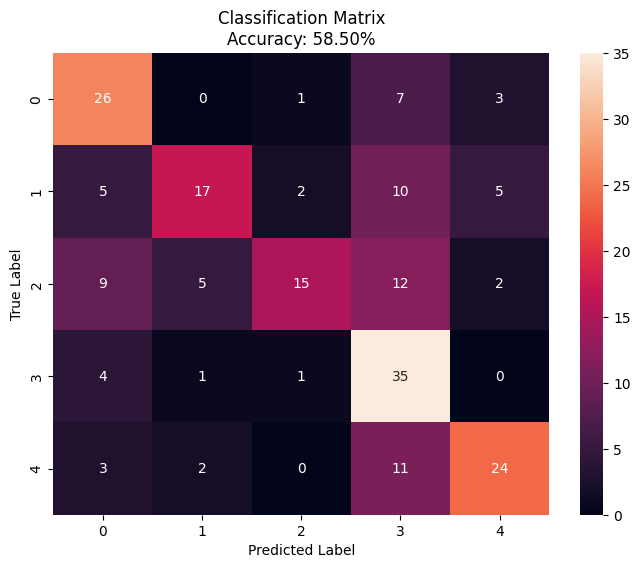

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

num_classes = 5

# Initialize the model
model = ConvNet(num_classes).to(device)
model.load_state_dict(torch.load('custom_cnn_5_class.pth'))
model.eval()

true_labels = []
pred_labels = []

# Iterate over the test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Calculate the classification matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calculate accuracy using the classification matrix
accuracy = (np.diag(conf_matrix).sum() / conf_matrix.sum()) * 100

# Plot the classification matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Classification Matrix\nAccuracy: {accuracy:.2f}%')
plt.show()


## Visualizing Output of CNN Layers and looking for Automatically created Features

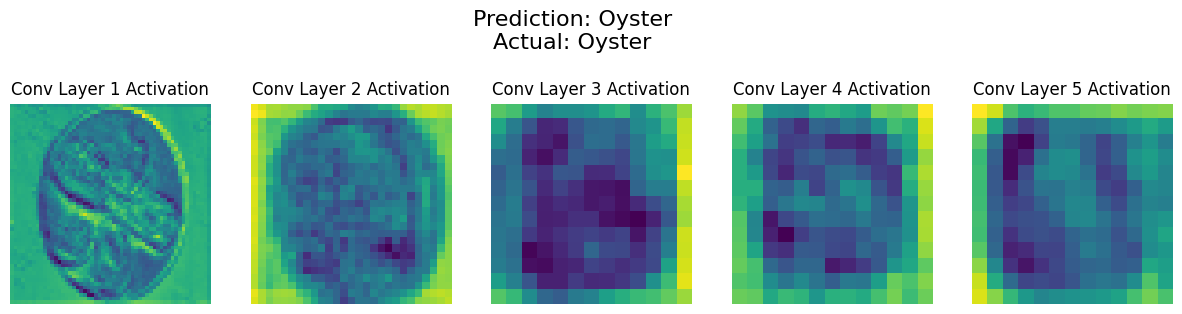

In [31]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, rows, cols, prediction, actual):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}',fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_5_class.pth'
model = ConvNet()

# Load the state dictionary of the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
labels=['Cat','Cow','Octopus','Oyster','Panda']
# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Get a random item from the list
random_item = random.choice(data_list)

# Extract image and label from the random item
input_image, input_label = random_item
actual = labels[input_label.cpu()]

model.eval()
output, intermediate_activations = model(input_image)
_, predicted = torch.max(output, 1)
prediction = labels[predicted.cpu()]
while prediction != actual:
    # Get a random item from the list
    random_item = random.choice(data_list)
    
    # Extract image and label from the random item
    input_image, input_label = random_item
    actual = labels[input_label.cpu()]
    
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
# Resize activation maps to a square shape for plotting
activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
activation_images_resized = [np.mean(image, axis=0) for image in activation_images]  # Compute channel-wise mean
titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

# Plot intermediate activations in a grid
plot_grid(activation_images_resized, titles, 1, 5, prediction, actual)

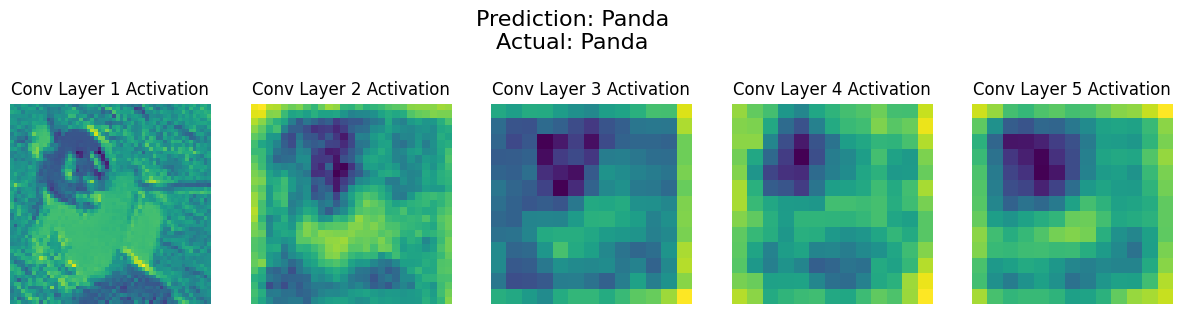

In [15]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, rows, cols, prediction, actual):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}',fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_5_class.pth'
model = ConvNet()

# Load the state dictionary of the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
labels=['Cat','Cow','Octopus','Oyster','Panda']
# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Get a random item from the list
random_item = random.choice(data_list)

# Extract image and label from the random item
input_image, input_label = random_item
actual = labels[input_label.cpu()]

model.eval()
output, intermediate_activations = model(input_image)
_, predicted = torch.max(output, 1)
prediction = labels[predicted.cpu()]
while prediction != actual:
    # Get a random item from the list
    random_item = random.choice(data_list)
    
    # Extract image and label from the random item
    input_image, input_label = random_item
    actual = labels[input_label.cpu()]
    
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
# Resize activation maps to a square shape for plotting
activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
activation_images_resized = [np.mean(image, axis=0) for image in activation_images]  # Compute channel-wise mean
titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

# Plot intermediate activations in a grid
plot_grid(activation_images_resized, titles, 1, 5, prediction, actual)

### Discussing automatically created features for identification of Panda
- The model identifies the head and body
- It identified facial features in the first layer such as eyes shaped as panda, nose, mputh and ears
- As we proceed in layers, the focus on head and body increases and facial features are disappeared

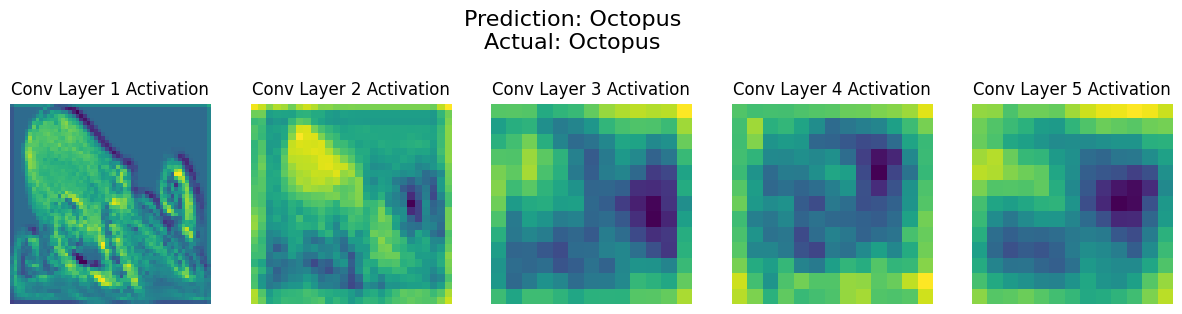

In [94]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, rows, cols, prediction, actual):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}',fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_5_class.pth'
model = ConvNet()

# Load the state dictionary of the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
labels=['Cat','Cow','Octopus','Oyster','Panda']
# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Get a random item from the list
random_item = random.choice(data_list)

# Extract image and label from the random item
input_image, input_label = random_item
actual = labels[input_label.cpu()]

model.eval()
output, intermediate_activations = model(input_image)
_, predicted = torch.max(output, 1)
prediction = labels[predicted.cpu()]
while prediction != actual:
    # Get a random item from the list
    random_item = random.choice(data_list)
    
    # Extract image and label from the random item
    input_image, input_label = random_item
    actual = labels[input_label.cpu()]
    
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
# Resize activation maps to a square shape for plotting
activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
activation_images_resized = [np.mean(image, axis=0) for image in activation_images]  # Compute channel-wise mean
titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

# Plot intermediate activations in a grid
plot_grid(activation_images_resized, titles, 1, 5, prediction, actual)

### Discussing automatically created features for identification of Octopus
- The model identifies the head and tentacles
- The focus in more on head like structure between or near tentacles connected to the it
- As we proceed in layers, the focus on head also reduces a bit

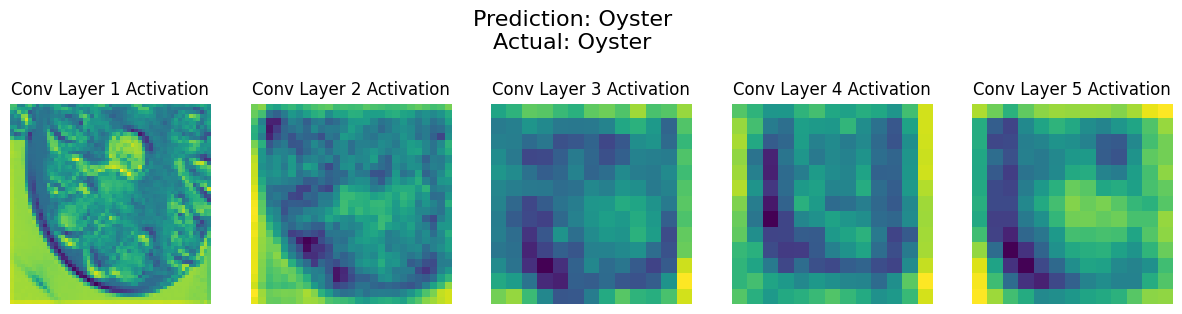

In [91]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, rows, cols, prediction, actual):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}',fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_5_class.pth'
model = ConvNet()

# Load the state dictionary of the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
labels=['Cat','Cow','Octopus','Oyster','Panda']
# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Get a random item from the list
random_item = random.choice(data_list)

# Extract image and label from the random item
input_image, input_label = random_item
actual = labels[input_label.cpu()]

model.eval()
output, intermediate_activations = model(input_image)
_, predicted = torch.max(output, 1)
prediction = labels[predicted.cpu()]
while prediction != actual:
    # Get a random item from the list
    random_item = random.choice(data_list)
    
    # Extract image and label from the random item
    input_image, input_label = random_item
    actual = labels[input_label.cpu()]
    
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
# Resize activation maps to a square shape for plotting
activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
activation_images_resized = [np.mean(image, axis=0) for image in activation_images]  # Compute channel-wise mean
titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

# Plot intermediate activations in a grid
plot_grid(activation_images_resized, titles, 1, 5, prediction, actual)

### Discussing automatically created features for identification of Oyster
- The model identifies the spaces in between and looks for oyster-like shape
- It looks for slot like structures
- It then focusses on the actual oyster more, eliminating the background

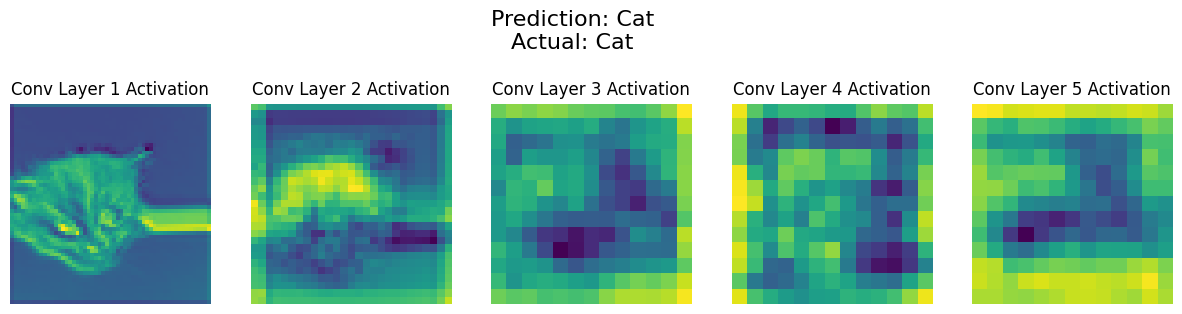

In [95]:
import torch
import random
import matplotlib.pyplot as plt

def plot_grid(images, titles, rows, cols, prediction, actual):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes.flatten()[i]
        ax.imshow(image, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f'Prediction: {prediction}\nActual: {actual}',fontsize=16)
    plt.show()

# Load the model from disk
model_path = 'custom_cnn_5_class.pth'
model = ConvNet()

# Load the state dictionary of the model
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)
labels=['Cat','Cow','Octopus','Oyster','Panda']
# Get input_image tensor from test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
data_list = list(test_loader)

# Get a random item from the list
random_item = random.choice(data_list)

# Extract image and label from the random item
input_image, input_label = random_item
actual = labels[input_label.cpu()]

model.eval()
output, intermediate_activations = model(input_image)
_, predicted = torch.max(output, 1)
prediction = labels[predicted.cpu()]
while prediction != actual:
    # Get a random item from the list
    random_item = random.choice(data_list)
    
    # Extract image and label from the random item
    input_image, input_label = random_item
    actual = labels[input_label.cpu()]
    
    output, intermediate_activations = model(input_image)
    _, predicted = torch.max(output, 1)
    prediction = labels[predicted.cpu()]
    
# Resize activation maps to a square shape for plotting
activation_images = [activation.squeeze().detach().cpu().numpy() for activation in intermediate_activations]
activation_images_resized = [np.mean(image, axis=0) for image in activation_images]  # Compute channel-wise mean
titles = [f'Conv Layer {i+1} Activation' for i in range(len(activation_images_resized))]

# Plot intermediate activations in a grid
plot_grid(activation_images_resized, titles, 1, 5, prediction, actual)

### Discussing automatically created features for identification of Cat
- The model identifies the and the eyes, nose etc. (facial features) first
- It then focusses more on the head and jaw
- Eventually, as we move on from one layer to another, the focus on the head increases

## Binary Classification using AlexNet (not pre-trained)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from torchvision.models import alexnet
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.features = alexnet().features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Define transformations and create dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update dataset directory to your 5-class dataset directory
dataset = datasets.ImageFolder('five-class/', transform=transform)

# Split dataset into three folds using KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

all_labels = []
all_predictions = []
all_accuracies = []

# Train and evaluate the model for each fold
for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    train_sampler = SubsetRandomSampler(train_index)
    test_sampler = SubsetRandomSampler(test_index)
    train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=16, sampler=test_sampler)

    # Define model, loss function, and optimizer
    model = AlexNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(num_epochs):  # You need to define num_epochs
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        print(f'Fold {fold+1}, Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader.dataset):.4f}')

    # Evaluate the model on test data after training
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())
    
    # Calculate accuracy for the current fold
    accuracy = accuracy_score(all_labels, all_predictions)
    all_accuracies.append(accuracy)
    print(f'Fold [{fold + 1}] Accuracy: {accuracy:.4f}')

# Calculate final accuracy across all folds
final_accuracy = np.mean(all_accuracies)
print(f'Final Accuracy: {final_accuracy:.4f}')

Fold 1, Epoch 1, Training Loss: 1.0693
Fold 1, Epoch 2, Training Loss: 1.0204
Fold 1, Epoch 3, Training Loss: 0.9608
Fold 1, Epoch 4, Training Loss: 0.8554
Fold 1, Epoch 5, Training Loss: 0.9104
Fold 1, Epoch 6, Training Loss: 0.8728
Fold 1, Epoch 7, Training Loss: 0.7820
Fold 1, Epoch 8, Training Loss: 0.7446
Fold 1, Epoch 9, Training Loss: 0.6400
Fold 1, Epoch 10, Training Loss: 0.6361
Fold [1] Accuracy: 0.3800
Fold 2, Epoch 1, Training Loss: 1.0755
Fold 2, Epoch 2, Training Loss: 1.0533
Fold 2, Epoch 3, Training Loss: 1.0308
Fold 2, Epoch 4, Training Loss: 0.9636
Fold 2, Epoch 5, Training Loss: 0.8872
Fold 2, Epoch 6, Training Loss: 0.8367
Fold 2, Epoch 7, Training Loss: 0.8187
Fold 2, Epoch 8, Training Loss: 0.9069
Fold 2, Epoch 9, Training Loss: 0.7060
Fold 2, Epoch 10, Training Loss: 0.6765
Fold [2] Accuracy: 0.4600
Fold 3, Epoch 1, Training Loss: 1.0750
Fold 3, Epoch 2, Training Loss: 1.0664
Fold 3, Epoch 3, Training Loss: 1.0445
Fold 3, Epoch 4, Training Loss: 0.9687
Fold 3, Ep

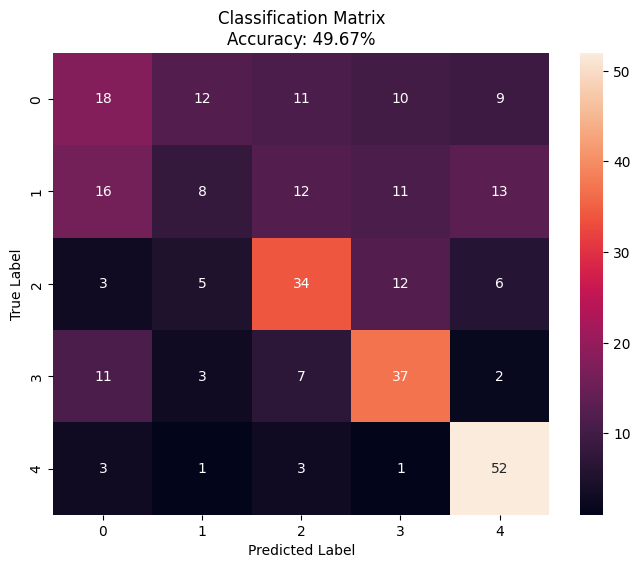

In [44]:
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy using the classification matrix
accuracy = (np.diag(conf_matrix).sum() / conf_matrix.sum()) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Classification Matrix\nAccuracy: {accuracy:.2f}%')
plt.show()

# Thank You!